In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.optimize as optimization
from tqdm import tqdm
from copy import deepcopy
from DiabaticPES import * # import the DiabaticPES code written by Philomena Schlexer Lamoureux (https://github.com/SUNCAT-Center/CatHub/blob/master/cathub/pet_barriers.py)
from AlkalineHER import * # import the AlkalineHER code which solves the kinetics of alkaline HER on Pt

In [2]:
# Plotting settings
#high quality figure setting
fig_width_pt = 1.8*246.0  # Get this from LaTeX using \showthe\columnwidth
#fig_width_pt *= 300./72 # convert to 300 dpi
inches_per_pt = 1.0/72.27               # Convert pt to inches
#inches_per_pt = 1.0/300               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

plt.rc('text', usetex=True)
plt.rc('text')
font = {'size': 18}
plt.rc('font', **font)
#sns.set_style('white')
sns.set_palette(sns.hls_palette(8, h=0.5, l=0.4, s=0.5))

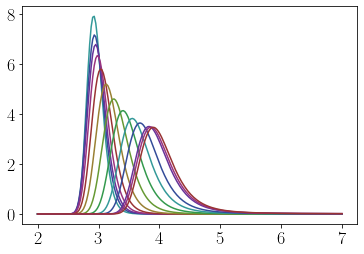

In [3]:
# check the electrode-solvent distribution at different H* coverage (cov)
prob_list=[]
for cov in [0,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.65,1]:
    prob_list.append(cov2distribution_Pt_100(cov,show_plot=True,N_sam=200)['Probability'])

In [4]:
# initiate the Pt(100)-water interface object
Pt100_w=ElectrodeWaterInterface('Pt','100')

energy difference:  0.27 V
E_H-OH in water: -3.54
E_H on metal: -3.27
d_O-metal:  3.80
bond_length_O-H:  1.00
bond_length_H-metal:  1.11
final_distance_metal-H:  1.69


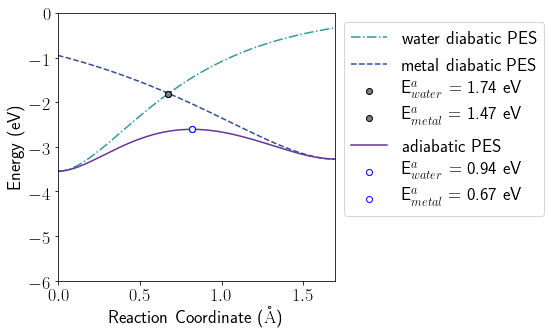

In [5]:
# show energy profile for Volmer step on Pt(100)-water interface
Volmer_barrier_Pt100=Pt100_w.get_volmer_parameters(coverage=0.75, U=-0.1, pH=13, d_ew=3.8, E_H_OH = -6.614, show_details = True)['barrier_ad_forward']

energy difference:  0.66 V
E_H-OH in water: -3.54
E_H_ad_H_metal: -2.88
d_O-metal:  3.80
bond_length_O-H:  1.00
bond_length_H-metal:  1.11
bond_length_H-H:  0.90
final_distance_metal-H:  0.79


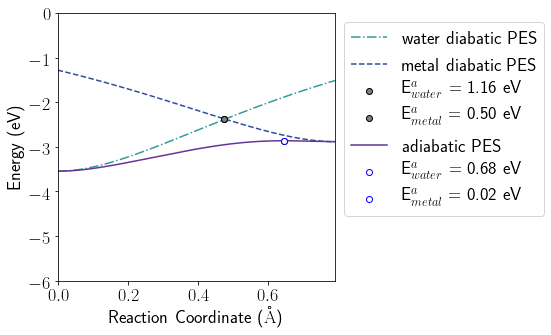

In [6]:
# show energy profile for Heyrovsky step on Pt(100)-water interface
Heyrov_barrier_Pt100=Pt100_w.get_heyrovsky_parameters(coverage=0.75, U=-0.1, pH=13, d_ew=3.8, E_H_OH = -6.614, show_details = True)['barrier_ad_forward']

In [7]:
# show details for Tafel step on Pt(100)-water interface
Tafel_barrier_Pt100=Pt100_w.get_tafel_parameters(coverage=0.75,show_details = True)['barrier_forward']

2*E_H_ad_metal: -6.55 eV
H2_referenced_to_H_vaccum: -6.73 eV
delta_E: -0.18 eV
forward barrier:  0.99 eV
reverse barrier:  1.18 eV


In [8]:
# distribution of kinetic parameters of HER on Pt(100) with aspect to electrode-solvent distance and potential U
distributions = Pt100_w.get_distributions(barrier_type = 'ad_diabetic', E_H_OH = -6.61, range_U = (-0.2,0), U_num = 100, 
                      pH = 13, initial_coverage = 0.9, iteration_number = 200, 
                      mixing = 0.01, precision=0.001)

100%|██████████| 200/200 [05:01<00:00,  5.32it/s]


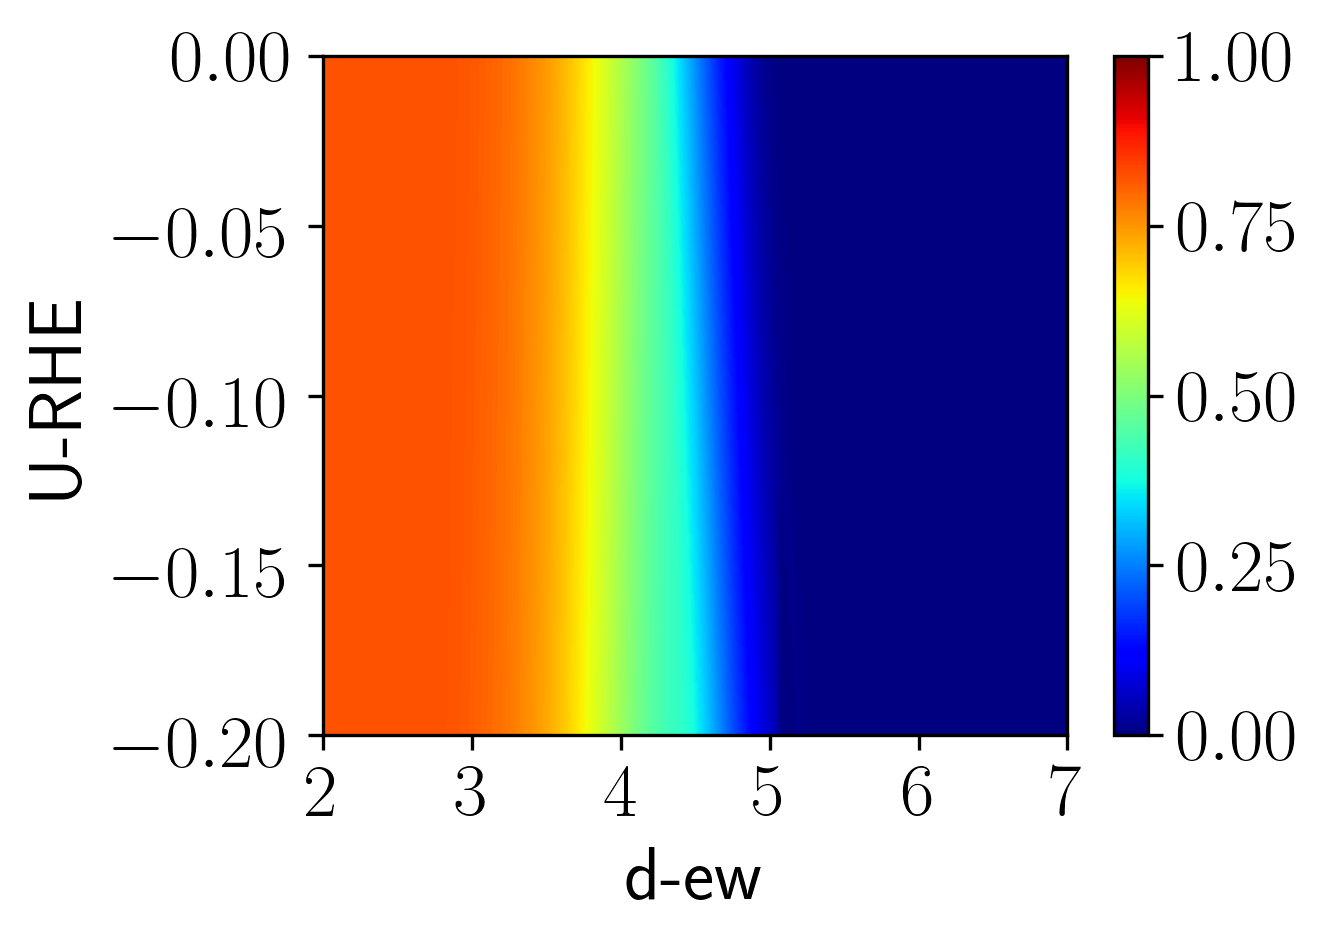

In [9]:
# H* coverage distribution on Pt(100)
plot_heatmap(distributions['Y_d_ew'], distributions['X_U'],distributions['Z_theta_H'],reselution=900,fig_size=[4,3],file_name = 'H_coverage_U_d',v_range=[0,1], nv=5)

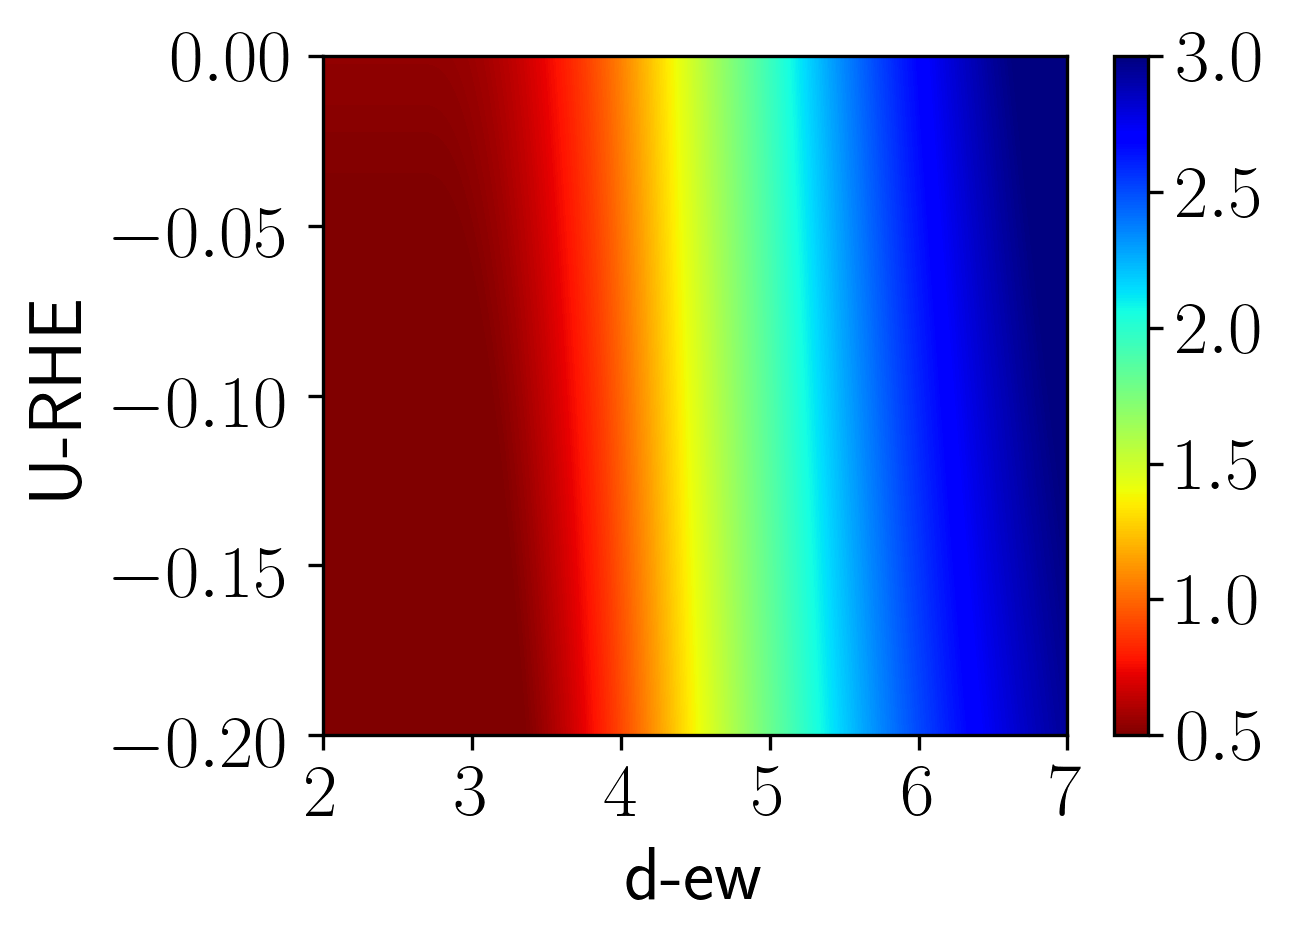

In [10]:
# forward barrier of Volmer step on P(100)
plot_heatmap(distributions['Y_d_ew'], distributions['X_U'],distributions['Z_barrier_volmer_f'],reselution=900,fig_size=[4,3],file_name = 'volmer_f_barrier',v_range=[0.5,3], nv=6,c_rev=True)

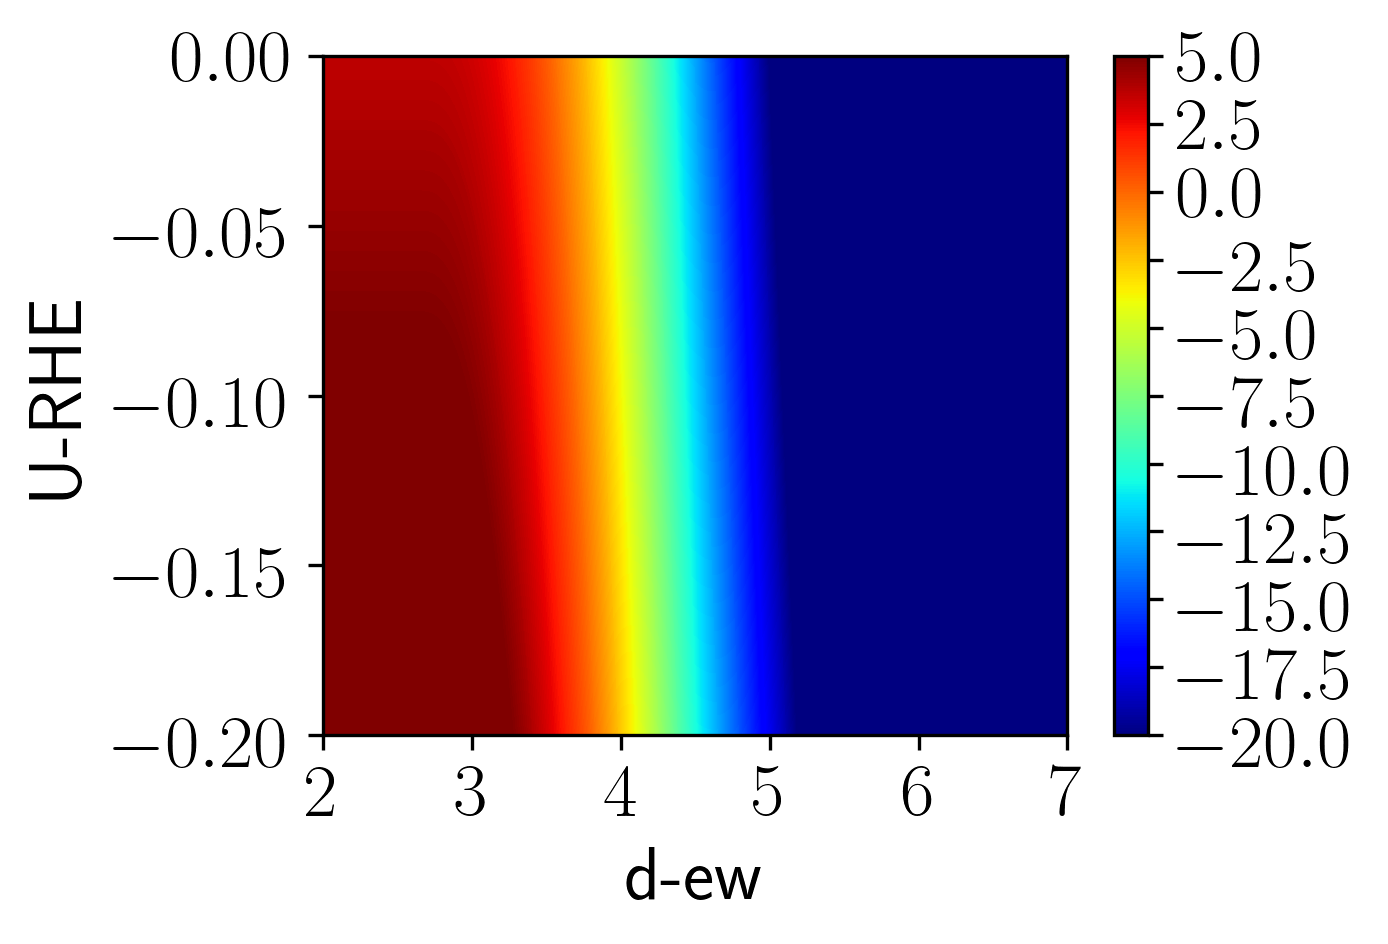

In [11]:
# intrinsic forward rate of Volmer step on P(100)
plot_heatmap(distributions['Y_d_ew'], distributions['X_U'],np.log10(distributions['Z_k_volmer_f']),fig_size=[4,3],reselution = 1000,file_name = 'vomer_f_intrinsic_rate',v_range=[-20,5], nv=11)

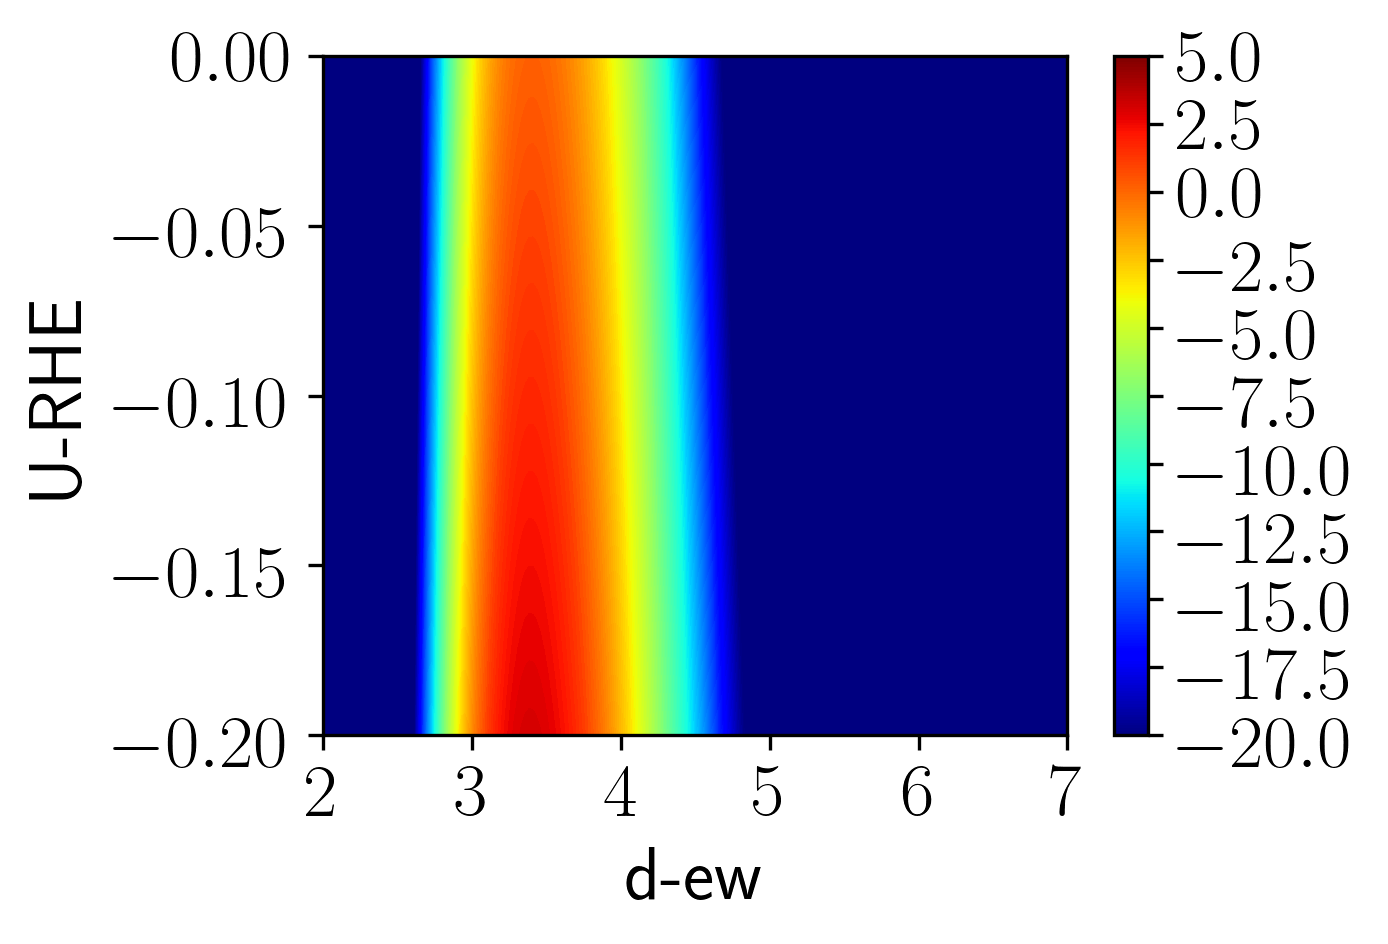

In [12]:
# probability-weighted forward rate of Volmer step on P(100)
plot_heatmap(distributions['Y_d_ew'], distributions['X_U'],np.log10(distributions['Z_k_volmer_f_probability_corrected']),fig_size=[4,3],file_name = 'vomer_f_probability_weighted_rate',v_range=[-20,5], nv=11)

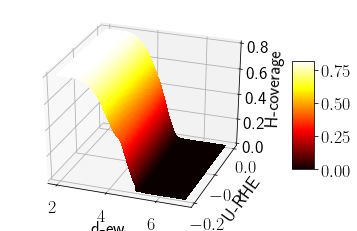

In [13]:
# show H* coverage on Pt(100) in 3D surface
plot_3D_surface(distributions['Y_d_ew'],distributions['X_U'],distributions['Z_theta_H'],Z_label='H-coverage')

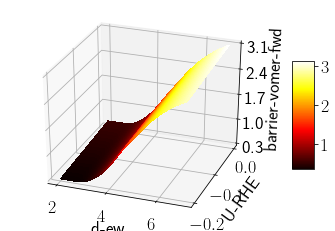

In [14]:
# show forward volmer barrier on Pt(100) in 3D surface
plot_3D_surface(distributions['Y_d_ew'],distributions['X_U'],distributions['Z_barrier_volmer_f'],file_name = '3D_barrier_volmer_f')

  0%|          | 1/200 [00:00<00:21,  9.29it/s]

range_U_RHE -0.1 0.0


100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


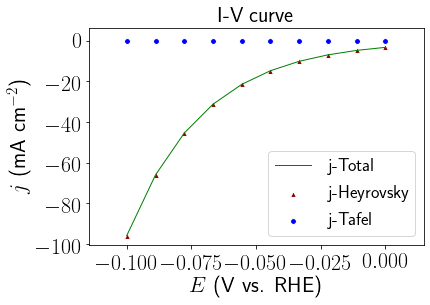

In [15]:
# simulate the IV curve on Pt(100)
Pt100_w=ElectrodeWaterInterface('Pt','100')
IV_curve_100 = Pt100_w.simulate_IV(barrier_type = 'ad_diabetic',range_U = (-0.1,0),U_ref='RHE', U_num = 10, pH = 13, initial_coverage = 0.75, iteration_number = 200,
                   mixing = 0.01, adjust=False,precision=0.001,plot=True,save_fig=True,H2O_var = 0)

In [16]:
# see ditails for IV curve on Pt(100)
IV_curve_100['U_RHE']

array([-0.1       , -0.08888889, -0.07777778, -0.06666667, -0.05555556,
       -0.04444444, -0.03333333, -0.02222222, -0.01111111,  0.        ])

In [17]:
# current density from Volmer-Heyrovsky mechanism
IV_curve_100['J_heyrov']*1000 # unit of mA/cm^2

array([95.82096287, 65.99918838, 45.42216264, 31.24196411, 21.4768996 ,
       14.75418661, 10.12971947,  6.95104507,  4.76681666,  3.26738828])

In [18]:
# current density from Volmer-Tafel mechanism
IV_curve_100['J_tafel']*1000 # unit of mA/cm^2

array([0.00020427, 0.00021163, 0.00021915, 0.00022685, 0.00023474,
       0.00024283, 0.00025108, 0.00025953, 0.00026817, 0.000277  ])

In [19]:
# total current density
IV_curve_100['J_total']*1000 # unit of mA/cm^2

array([95.82116713, 65.99940001, 45.42238179, 31.24219096, 21.47713435,
       14.75442944, 10.12997055,  6.9513046 ,  4.76708483,  3.26766528])

  0%|          | 1/200 [00:00<00:30,  6.52it/s]

range_U_RHE -0.1 0.0


100%|██████████| 200/200 [00:17<00:00, 11.63it/s]


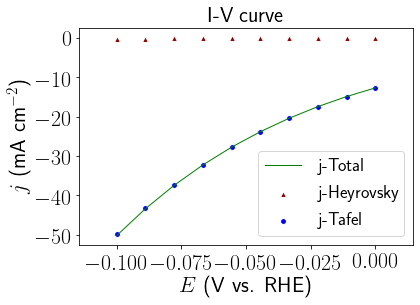

In [20]:
# simulate the IV curve on Pt(111)
Pt111_w=ElectrodeWaterInterface('Pt','111')
IV_curve_111 = Pt111_w.simulate_IV(barrier_type = 'ad_diabetic',range_U = (-0.1,0),U_ref='RHE', U_num = 10, pH = 13, initial_coverage = 0.75, iteration_number = 200,
                   mixing = 0.1, adjust=False,precision=0.001,plot=True,save_fig=True,H2O_var = 0)

  0%|          | 0/200 [00:00<?, ?it/s]

range_U_RHE -0.2 0.0


100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


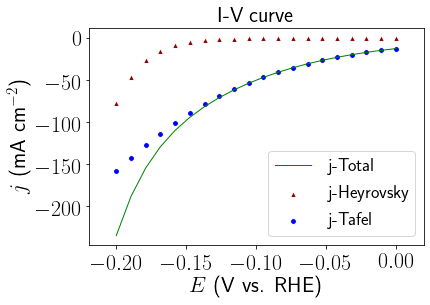

In [21]:
# IV curve on Pt(111) at more negative potential
IV_curve_111_b = Pt111_w.simulate_IV(barrier_type = 'ad_diabetic',range_U = (-0.2,0),U_ref='RHE', U_num = 20, pH = 13, initial_coverage = 0.9, iteration_number = 200,
                   mixing = 0.025, adjust=False,precision=0.001,plot=True,save_fig=True,H2O_var = 0)